In [1]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.xbox2_specific.datasets.XBOX2_trend_all_bd_20ms import XBOX2TrendAllBD20msSelect
from src.utils.dataset_creator import load_dataset

2021-11-09 15:19:01.180296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-09 15:19:01.180312: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset
To load a dataset the dataset name and path to data has to be supplied.
This information is then passed to the `load_dataset` function which returns training, validation and test set.

For the xbox2 dataset some additional information is passed to the dataset loader.
First, the `manual_split` argument can be used to specify custom splitting of the data using run numbers.
Secondly, the `manual_scale` argument can be used to specify if scaling should
be done using mean and variance of each run.

In [2]:
train_runs = [2, 4, 5, 6, 8, 9]
valid_runs = [1, 7]
test_runs = [3]

path_to_data = Path("/eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/Xbox2_hdf_new2/")

train, valid, test = load_dataset(creator=XBOX2TrendAllBD20msSelect(),
                                  data_path=path_to_data,
                                  manual_split=(train_runs, valid_runs, test_runs),
                                  manual_scale=[1, 2, 3, 4, 5, 6, 7, 8, 9])

2021-11-09 15:28:32.170260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-09 15:28:32.195436: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-09 15:28:32.207651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hsb-cern): /proc/driver/nvidia/version does not exist
2021-11-09 15:28:32.529130: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Plot Dataset
A good sanity check is to plot the data and checking if the data looks as expected.

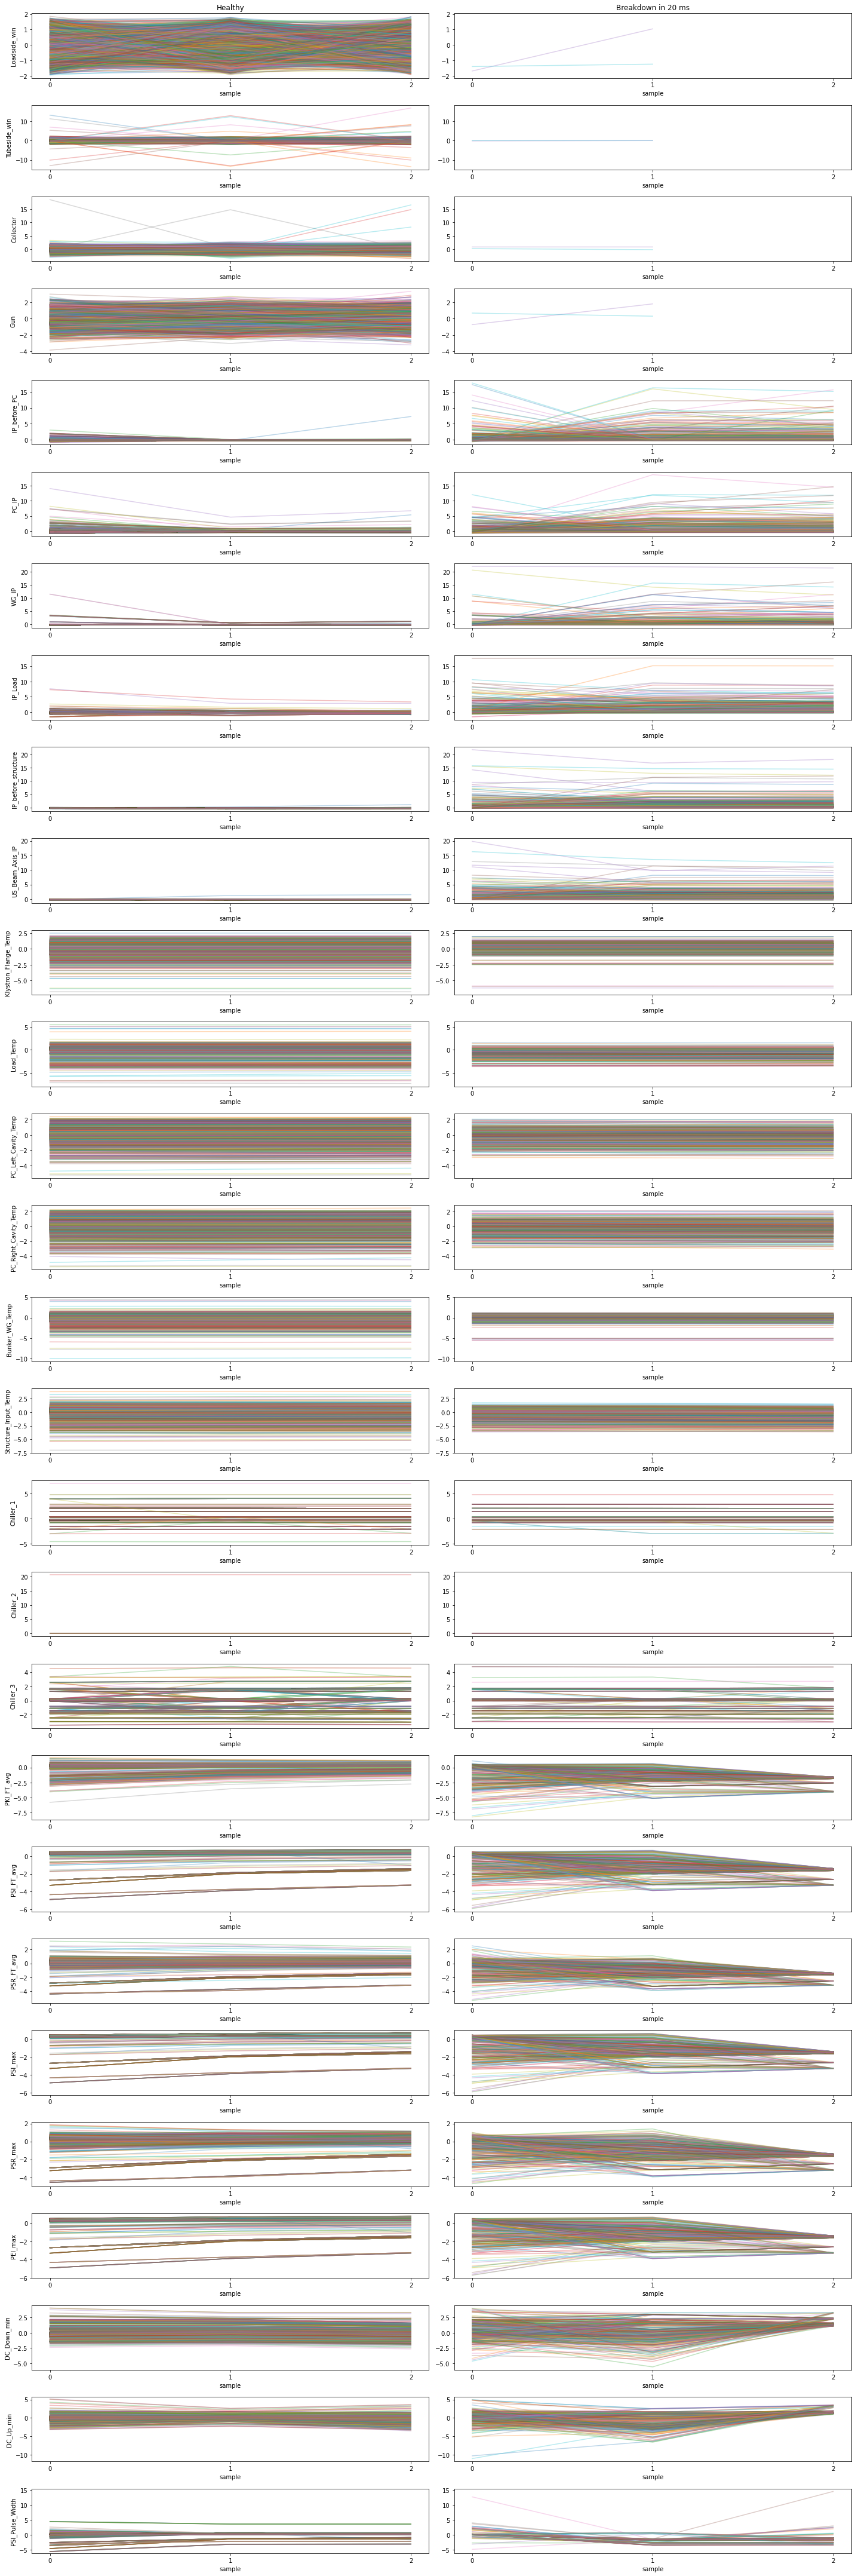

In [12]:
n_features = len(train.X.feature)

fig, ax = plt.subplots(n_features,2, figsize=(20,60))
for i in range(n_features):
    ax[i, 0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,i].values.T, alpha=0.3)
    ax[i, 0].set_xlabel("sample")
    ax[i, 0].set_ylabel(train.X.feature[i].values)
    ax[i, 0].set_xticks([0, 1, 2])
    ax[i, 1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,i].values.T, alpha=0.3)
    ax[i, 1].set_xlabel("sample")
    ax[i, 1].set_xticks([0, 1, 2])
    bottom0, top0 = ax[i, 0].set_ylim()
    bottom1, top1 = ax[i, 1].set_ylim()
    ax[i, 0].set_ylim([min([bottom0, bottom1]), max([top0, top1])])
    ax[i, 1].set_ylim([min([bottom0, bottom1]), max([top0, top1])])

ax[0, 0].set_title("Healthy")
ax[0, 1].set_title("Breakdown in 20 ms")
fig.tight_layout()
plt.show()

# Getting data ready for machine learning
Before the data is sent to the machine learning models we need to convert them from xarray DataArrays into standard numpy arrays. This can be done manually or using the helper function found in the dataset_creator module.

In [13]:
from src.utils.dataset_creator import da_to_numpy_for_ml
train_numpy, valid_numpy, test_numpy = da_to_numpy_for_ml(train, valid, test)

# Create and Use Classifier Model
To create a classifier model an instance of the `Classifier` class is created.
To do this some hyperparameters are needed. These are loaded from a ´.json´ file.

In [14]:
# Load hyperparameters into dictionary
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

# Create model
clf = Classifier(input_shape=train_numpy.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)

## Fit Model
After the model is created it has to be fitted to the data. This is done using the `fit_classifier` method.
Alternatively if a model already has been trained, the trained weights can be loaded.
In this example we simply load pretrained weights as training is time-consuming.

In [15]:
# Fit model to training set and validate on validation set
clf.fit_classifier(train_numpy, valid_numpy)
# load weights from an already trained model
# clf.model.load_weights(Path(api_dir) / "src/model/trained_models/trend_all_bd_20ms.hdf5")

2021-11-09 15:46:43.842645: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
131/131 [==============================] - 5s 7ms/step - loss: 0.0673 - tp: 2060.0000 - fp: 28.0000 - tn: 2060.0000 - fn: 28.0000 - accuracy: 0.9866 - precision: 0.9866 - recall: 0.9866 - auc: 0.9967 - prc: 0.9960 - val_loss: 0.2034 - val_tp: 559.0000 - val_fp: 26.0000 - val_tn: 559.0000 - val_fn: 26.0000 - val_accuracy: 0.9556 - val_precision: 0.9556 - val_recall: 0.9556 - val_auc: 0.9826 - val_prc: 0.9793
Epoch 2/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0081 - tp: 2080.0000 - fp: 8.0000 - tn: 2080.0000 - fn: 8.0000 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - auc: 0.9995 - prc: 0.9993 - val_loss: 0.0560 - val_tp: 581.0000 - val_fp: 4.0000 - val_tn: 581.0000 - val_fn: 4.0000 - val_accuracy: 0.9932 - val_precision: 0.9932 - val_recall: 0.9932 - val_auc: 0.9964 - val_prc: 0.9954
Epoch 3/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0012 - tp: 2087.0000 - fp: 1.0000 - tn: 2087.0000 - fn: 1.0000 - accuracy: 0.9995

131/131 [==============================] - 0s 3ms/step - loss: 6.5299e-07 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0340 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 21/500
131/131 [==============================] - 0s 3ms/step - loss: 5.6682e-07 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0343 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 22/500
131/131 [==============================] - 0s 3ms/step - loss: 5.0286e-07 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e

Epoch 39/500
131/131 [==============================] - 0s 3ms/step - loss: 9.9216e-08 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0369 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 40/500
131/131 [==============================] - 0s 3ms/step - loss: 9.1324e-08 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0370 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 41/500
131/131 [==============================] - 0s 3ms/step - loss: 8.3497e-08 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 

Epoch 58/500
131/131 [==============================] - 0s 3ms/step - loss: 2.4733e-08 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0385 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 59/500
131/131 [==============================] - 0s 3ms/step - loss: 2.3669e-08 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0384 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 60/500
131/131 [==============================] - 0s 3ms/step - loss: 2.2780e-08 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 

Epoch 77/500
131/131 [==============================] - 0s 4ms/step - loss: 1.0057e-08 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0393 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 78/500
131/131 [==============================] - 0s 3ms/step - loss: 9.6134e-09 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0394 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 79/500
131/131 [==============================] - 0s 3ms/step - loss: 8.9972e-09 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 

Epoch 96/500
131/131 [==============================] - 0s 3ms/step - loss: 3.4899e-09 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0398 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 97/500
131/131 [==============================] - 0s 3ms/step - loss: 3.1824e-09 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0396 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 98/500
131/131 [==============================] - 0s 3ms/step - loss: 2.9766e-09 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 

Epoch 115/500
131/131 [==============================] - 0s 3ms/step - loss: 1.4369e-09 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0394 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 116/500
131/131 [==============================] - 0s 3ms/step - loss: 1.4026e-09 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0394 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 117/500
131/131 [==============================] - 0s 3ms/step - loss: 1.3683e-09 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 134/500
131/131 [==============================] - 0s 3ms/step - loss: 5.4754e-10 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0388 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 135/500
131/131 [==============================] - 0s 3ms/step - loss: 5.4754e-10 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0387 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 136/500
131/131 [==============================] - 0s 3ms/step - loss: 5.1325e-10 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 153/500
131/131 [==============================] - 0s 3ms/step - loss: 1.0288e-10 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0378 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 154/500
131/131 [==============================] - 0s 3ms/step - loss: 1.0288e-10 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0376 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 155/500
131/131 [==============================] - 0s 3ms/step - loss: 1.0288e-10 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 172/500
131/131 [==============================] - 0s 3ms/step - loss: 3.4295e-11 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0372 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 173/500
131/131 [==============================] - 0s 3ms/step - loss: 3.4295e-11 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0371 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 174/500
131/131 [==============================] - 0s 3ms/step - loss: 3.4295e-11 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 191/500
131/131 [==============================] - 0s 3ms/step - loss: 3.4295e-11 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0361 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 192/500
131/131 [==============================] - 0s 3ms/step - loss: 3.4295e-11 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0361 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 193/500
131/131 [==============================] - 0s 3ms/step - loss: 3.4295e-11 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 210/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0361 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 211/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0361 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 212/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 229/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0361 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 230/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0361 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 231/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 248/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0360 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 249/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0359 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 250/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 267/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0359 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 268/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0359 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 269/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 286/500
131/131 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0358 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 287/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0358 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 288/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 305/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0357 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 306/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0357 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 307/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 324/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0356 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 325/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0356 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 326/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 343/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0356 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 344/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0356 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 345/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 362/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0355 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 363/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0355 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 364/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 381/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0355 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 382/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0355 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 383/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 400/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0354 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 401/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0354 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 402/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 419/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0354 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 420/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0354 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 421/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 438/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0353 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 439/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0353 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 440/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 457/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0353 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 458/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0353 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 459/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 476/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0352 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 477/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0353 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 478/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

Epoch 495/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0352 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 496/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0352 - val_tp: 584.0000 - val_fp: 1.0000 - val_tn: 584.0000 - val_fn: 1.0000 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 497/500
131/131 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - tp: 2088.0000 - fp: 0.0000e+00 - tn: 2088.00

## Make Prediction
When the model has been fitted to the data, it can be used to make predictions.
Here the prediction is done on the kept out test set using the `predict` method.

In [19]:
y_pred = clf.model.predict(x=test_numpy.X)
y_pred

array([[1.0000000e+00, 5.4863606e-18],
       [1.0000000e+00, 1.7353008e-17],
       [1.0000000e+00, 3.0091805e-18],
       ...,
       [1.0000000e+00, 3.4708337e-14],
       [1.0000000e+00, 5.4028183e-14],
       [1.0000000e+00, 7.4484867e-15]], dtype=float32)

## Evaluate Model
To evaluate the performance of the model, the `evaluate` method can be used.

In [20]:
# eval classifier
results = clf.model.evaluate(x=test_numpy.X, y=test_numpy.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

20/20 [==============================] - 0s 1ms/step - loss: 0.0126 - tp: 623.0000 - fp: 2.0000 - tn: 623.0000 - fn: 2.0000 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - auc: 1.0000 - prc: 1.0000      


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.012625,623.0,2.0,623.0,2.0,0.9968,0.9968,0.9968,0.999969,0.999969
